# Testing GPU-based IMRPhenom with Ripple
-- Comparison with LALSimulation and PyCBC

### Package Installations

In [19]:
! pip install lalsuite
! pip install -U jax jaxlib
! pip install ripplegw
! pip install matplotlib
! pip install gwosc
! pip install gwpy
! pip install scipy
! pip install numpy

  Using cached lalsuite-7.21-cp39-cp39-manylinux_2_28_x86_64.whl.metadata (3.1 kB)
  Using cached lscsoft_glue-3.0.1-cp39-cp39-linux_x86_64.whl
  Using cached pyOpenSSL-23.3.0-py3-none-any.whl.metadata (12 kB)
  Using cached pyRXP-3.0.1-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (297 kB)
Using cached lalsuite-7.21-cp39-cp39-manylinux_2_28_x86_64.whl (43.1 MB)
Using cached pyOpenSSL-23.3.0-py3-none-any.whl (58 kB)


### Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

import numpy as np
from math import pi
from functools import partial

In [2]:
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries
from scipy.signal.windows import tukey

In [3]:
import jax.numpy as jnp

from ripple import ms_to_Mc_eta
from ripple.waveforms.IMRPhenomD import gen_IMRPhenomD_hphc
from ripple.waveforms.IMRPhenomPv2 import gen_IMRPhenomPv2_hphc

In [4]:
import lal
import lalsimulation as lalsim

In [263]:
from pycbc.types import TimeSeries

## LALSimulation Implementaiton of IMRPhenomD

In [271]:
approximant = lalsim.SimInspiralGetApproximantFromString("IMRPhenomD")
m1_msun = 20.0 # In solar masses
m2_msun = 19.0
chi1 = 0.0
chi2 = 0.0
tc = 0.0 # Time of coalescence in seconds
phic = 0.0
dist_mpc = 440 # Distance to source in Mpc
inclination = 0.0 # Inclination Angle
m1_kg = m1_msun*lal.MSUN_SI
m2_kg = m2_msun*lal.MSUN_SI
distance = dist_mpc*1e6*lal.PC_SI

# Params for freq domain waveform
T = 20
f_min = 20.0
f_max = 2048.0
f_ref = f_min
f_sampling = 4096.
delta_t = 1 / f_sampling
tlen = int(round(T / delta_t))
freqs = np.fft.rfftfreq(tlen, delta_t)
df = freqs[1] - freqs[0]

hp, hc = lalsim.SimInspiralChooseFDWaveform(m1_kg, m2_kg,
                                            0., 0., chi1,
                                            0., 0., chi2,
                                            distance, inclination,
                                            phic, 0, 0., 0.,
                                            df, f_min, f_max, f_ref,
                                            None, approximant)
hp_lalsim = hp.data.data
hc_lalsim = hc.data.data

In [274]:
# hp_lalsim_td = np.fft.irfft(hp_lalsim) / (1./f_sampling)
hp_lalsim_td = TimeSeries(hp.data.data[:], delta_t=hp.deltaT, epoch=hp.epoch)

plt.figure(figsize=(10.0, 4.0))
plt.plot(hp_lalsim_td)
plt.xlabel('Samples')
plt.ylabel('Strain')
plt.show()

AttributeError: 'lal.COMPLEX16FrequencySeries' object has no attribute 'deltaT'

## PyCBC Implementation of IMRPhenom (Comparison)

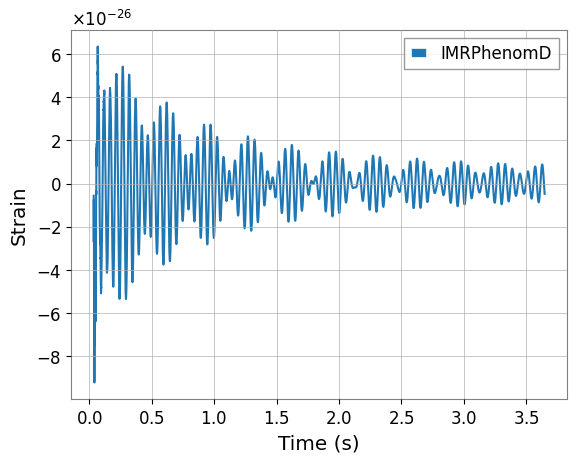

In [283]:
import matplotlib.pyplot as pp
from pycbc.waveform import get_td_waveform

m1_msun = 20.0 # In solar masses
m2_msun = 19.9
chi1 = 0.0
chi2 = 0.0
tc = 0.0 # Time of coalescence in seconds
phic = 0.0
dist_mpc = 440 # Distance to source in Mpc
inclination = 0.0 # Inclination Angle
polarization_angle = 0 # Polarization angle

f_ref = 20.0

for apx in ['IMRPhenomD']:
    hp_pycbc, hc_pycbc = get_td_waveform(approximant=apx,
                                    mass1=m1_msun,
                                    mass2=m2_msun,
                                    spin1z=chi1,
                                    spin2z=chi2,
                                    delta_t=1.0/4096,
                                    f_lower=20.0,
                                    f_ref=20.0,
                                    distance=dist_mpc,
                                    polarization=polarization_angle,
                                    inclination=inclination)

    limits = slice(45200, 60000)
    pp.plot(hp_pycbc.sample_times[limits], hp_pycbc[limits], label=apx)

pp.ylabel('Strain')
pp.xlabel('Time (s)')
pp.legend()
pp.show()

In [72]:
print(hp[45000:])

[-9.60270213e-22 -1.06329006e-21 -1.14340029e-21 ...
  2.74682138e-27  2.92654654e-27  3.10596522e-27]


## IMRPhenomPv2 with signal length

In [314]:
import jax
# Jax jitted version of waveform gen returns NaNs without this
# It may also return NaNs if improper arguments are provided (eg. PhenomD args for PhenomPv2)
jax.config.update("jax_enable_x128", True)

AttributeError: Unrecognized config option: jax_enable_x128

In [328]:
IMRphenom = 'IMRPhenomD'

m1_msun = 50.0 # In solar masses
m2_msun = 49.9
chi1 = 0.0
chi2 = 0.0
tc = 0.0 # Time of coalescence in seconds
phic = 0.0
dist_mpc = 6000 # Distance to source in Mpc
inclination = 0.0 # Inclination Angle
polarization_angle = 0 # Polarization angle

Mc, eta = ms_to_Mc_eta(jnp.array([m1_msun, m2_msun]))

params = jnp.array([Mc, eta, chi1, chi2, dist_mpc, tc, phic, inclination, polarization_angle])

# Get a frequency domain waveform
f_l = 20.0
f_u = 2048.0
T = 20.

f_sampling = 4096.0
delta_t = 1 / f_sampling
tlen = int(round(T / delta_t))
freqs = np.fft.rfftfreq(tlen, delta_t)
df = freqs[1] - freqs[0]
fs = freqs[(freqs >= f_l) & (freqs <= f_u)]
f_ref = f_l

fs = np.arange(0.0, 4096.0, 0.01)
print(fs)

[0.00000e+00 1.00000e-02 2.00000e-02 ... 4.09597e+03 4.09598e+03
 4.09599e+03]


In [329]:
def waveform(theta):
    hp, _ = gen_IMRPhenomD_hphc(fs[1:], theta, f_ref)
    return hp

In [330]:
hp_ripple = waveform(params)
# restore zero-frequency component
hp_ripple = np.insert(hp_ripple, 0, 0)
hp_ripple = np.array(hp_ripple)
hp_ripple[fs < 20] = 0.0
print(hp_ripple)

[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]


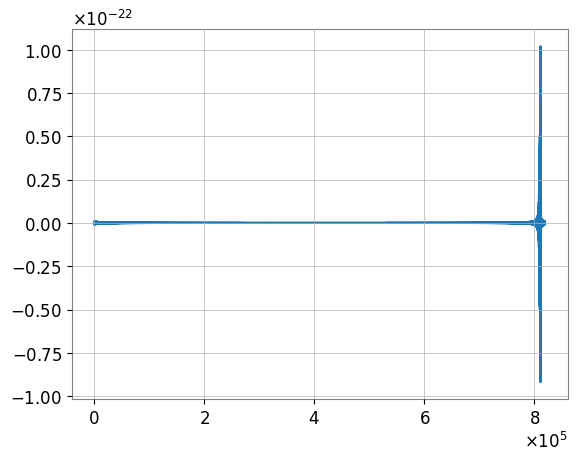

Sample duration observed = 199.99951171875


In [332]:
# Time shift lalsim data to account for ringdown (at least 0.1 seconds?)
wraparound = 0.5
hp_ripple = hp_ripple * np.exp(1j*2.*np.pi*fs*wraparound)

hp_ripple_td = np.fft.irfft(hp_ripple) / (1./f_sampling)
plt.plot(hp_ripple_td)
# plt.plot(hp_pycbc[:], alpha=0.5)
#plt.xlim(35000, 41000)
plt.show()
print('Sample duration observed = {}'.format(len(hp_ripple_td)/4096.))

## Using IMRPhenomPv2 with JIT for faster computation

In [1]:
# Note that we have not internally jitted the functions since this would
# introduce an annoying overhead each time the user evaluated the function with a different length frequency array
# We therefore recommend that the user jit the function themselves to accelerate evaluations. For example:
import time

# Enable this just in case the jitted function produces NaNs
jax.config.update("jax_debug_nans", True)

NameError: name 'jax' is not defined

In [ ]:
# Now we need to generate the frequency grid
# Sampling frequency
f_l = 20
f_u = 1024
del_f = 0.01
sample_length_in_s = 1./del_f
fs = jnp.arange(f_l, f_u, del_f)
f_ref = f_l

In [ ]:
def get_waveform_kwargs(seed):
    # And finally lets generate the waveform (IMRPhenomPv2)!
    # Get a frequency domain waveform
    # source parameters
    np.random.seed(seed)
    masses = [np.random.uniform(5.0, 50.0), np.random.uniform(5.0, 50.0)]
    m1_msun = max(masses)
    m2_msun = min(masses)
    s1x = 0.5
    s1y = -0.5
    s1z = 0.5
    s2x = -0.5
    s2y = 0.5
    s2z = -0.5
    dist_mpc = 440.0
    tc = 0.0
    phiRef = 0.5
    incl = 0.5
    
    Mc, eta = ms_to_Mc_eta(jnp.array([m1_msun, m2_msun]))
    theta_ripple = jnp.array([Mc, eta, s1x, s1y, s1z, s2x, s2y, s2z, dist_mpc, tc, phiRef, incl])

    return theta_ripple

In [ ]:
@jax.jit
def waveform_generate(theta):
    data = IMRPhenomPv2.gen_IMRPhenomPv2_hphc(fs, theta, f_ref)
    return data

In [ ]:
num_waveforms = 100
for idx in range(num_waveforms):
    theta_ripple = get_waveform_kwargs(idx+100)
    hp_ripple, hc_ripple = waveform_generate(theta_ripple)